# Simple Customer Prediction

This notebook shows a simple example of how to use Intelligent Element to train a model that handles data with nested structures.

In this simulated example, we will predict whether a customer of a restaurant will come back next week.

## Features

Features are:

- client age (12-70)
- client gender (0-male, 1-female)
- number of children (0-5)
- client relative income (continous from 0 - low income to 1 - high income)
- List of whether the customer was present in the last 30 days containing:
    - customer present? (1-yes, 0-no)
    - customer rating (from  0-bad to 1-excellent)
    - time spent in restaurant (0-as little as possible, 1-much longer than necessary)
    - List of items ordered 
        - Price (0-cheap for item to 1-expensive for item);
        - Average quality rating (0-bad to 1-excellent);
    
The last element of the list is yesterday, the second to last is the day before and so on.

## Rule Set

To generate the simulated data, a set of rules will be created. Let's start with some assumptions:

- Young people (<25) prefer to spend small amounts of time in the restaurant;
- Older people (>45) prefer to spend longer in the restaurant;
- No one likes to spend too much time in the restaurant;
- Everyone likes lower prices and better quality products;
- Men value price more;
- Women value quality more;
- If the quality of one or more products is too low (<0.1) it has a very significant negative impact;
- Customers are more likely to come back if they come often and give a high rating often;
- When clients give a good rating at a given day, it means that they liked that particular combination and are more likely to come back;
- The more children, the less likely a customer to come next week.

Note that a deep learning model will need to learn how to relate data from the internal list with, for example, gender. It will also need to "remember" if the score of a given product was too low.

Based on these assumptions, we create the following "comeback" score:

In [0]:
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt

In [0]:
def order_score(order_avg, order_toobad, gender, score, timespent, age):
    if gender == 0:
        #men value price
        s = (1-order_avg[0])*1.4+order_avg[1]
    else:
        #women value quality
        s = order_avg[0]+1.5*order_avg[1]
        
    s *= np.exp(-order_toobad)
    s *= (1+score)
    
    if timespent >= 0.9:
        s *= 0.4
    else:
        if timespent >= 0.6 and age >= 45:
            s *= 1.1
        elif timespent <= 0.3 and age <= 25:
            s *= 1.3
    return s

def customer_score(c):
    #pick features from last visits
    last30 = [ [x['present'], x['rating'], x['time_spent']] for x in c['last_30'] if x['present']==1]
    
    order_data = [x['order'] for x in c['last_30'] if x['present']==1]
    order_avgs = [np.mean(x, axis=0) for x in order_data]
    
    #how many orders were too bad?
    order_toobad = np.array([(np.sum(np.array(x)<=0.1,axis=0)>=1).astype(int) for x in order_data])[:,1]
    order_scores = [order_score(order_avgs[k], order_toobad[k], c['gender'], last30[k][1], last30[k][2], c['age'])  for k in range(len(last30))]
    
    s = np.mean(order_scores)

    s -= c['n_children']*0.1
    s *= (1+c['income'])
    
    if s<0:
        s=0
    #print(order_scores)

    return s

Let's simulate some clients:

In [4]:
#a client that is not likely to return
customer_data={'age': 55, 'gender' : 0, 'n_children' : 4, 'income' : 0.3,
               'last_30' : [
                   {'present' : 1, 'rating':0.3,'time_spent':0.3, 'order': [ [0.8,0.3], [0.6,0.2] ] },
                   {'present' : 0, 'rating':0,  'time_spent':0,   'order': [ [0,0] ] },
                   {'present' : 0, 'rating':0,  'time_spent':0,   'order': [ [0,0] ] },
                   {'present' : 1, 'rating':0.4,'time_spent':0.7, 'order': [ [0.8,0.8], [0.6,0.1] ] },
                   {'present' : 0, 'rating':0,  'time_spent':0,   'order': [ [0,0] ] },
                   {'present' : 1, 'rating':0.2,'time_spent':0.3, 'order': [ [0.9,0.2], [0.8,0.2], [0.7,0.2] ] }
               ]
              }
customer_score(customer_data)

0.32061677928864923

In [5]:
#a client that is likely to return
customer_data={'age': 22, 'gender' : 0, 'n_children' : 2, 'income' : 0.6,
               'last_30' : [
                   {'present' : 1, 'rating':0.7,'time_spent':0.4, 'order': [ [0.8,0.8], [0.6,0.9] ] },
                   {'present' : 1, 'rating':0.8,'time_spent':0.4, 'order': [ [0.8,0.8], [0.6,0.9] ] },
                   {'present' : 0, 'rating':0,  'time_spent':0,   'order': [ [0,0] ] },
                   {'present' : 1, 'rating':0.9,'time_spent':0.3, 'order': [ [0.3,0.8], [0.6,0.8], [0.6,0.7] ] }
               ]
              }
customer_score(customer_data)

3.982755555555555

# Data Generation

Let us generate a simple synthetic dataset and check the histogram:

In [0]:
def gen_client_data():
    ans = {'age' :        np.random.randint(12,70),
           'gender' :     np.random.randint(2),
           'n_children' : np.random.randint(6),
           'income' :     np.random.uniform(0,1),
           'last_30' :     []
          }
    
    n_lastvisits = np.random.randint(2,31)
    for k in range(n_lastvisits):
        if np.random.uniform(0,1) < 0.6 and len(ans['last_30']) > 0:
            ans['last_30'].append( {'present' : 0, 'rating':0,  'time_spent':0,   'order': [[0,0]] } )
        else:
            day_data = { 
                         'present' :    1,
                         'rating' :     np.random.uniform(0,1),
                         'time_spent' : np.random.uniform(0,1),
                       }
            
            n_order = np.random.randint(5,16)
            day_data['order'] = [ [np.random.uniform(0,1),np.random.uniform(0,1)] for k in range(n_order) ]

            ans['last_30'].append(day_data)
    
    
    return ans

(array([12., 13., 19., 32., 40., 45., 64., 82., 84., 76., 71., 72., 73.,
        61., 43., 43., 27., 33., 30., 21., 11., 13.,  5.,  6.,  5.,  5.,
         4.,  1.,  2.,  2.,  1.,  0.,  1.,  1.,  0.,  0.,  0.,  0.,  0.,
         2.]),
 array([0.        , 0.11391494, 0.22782988, 0.34174482, 0.45565976,
        0.5695747 , 0.68348964, 0.79740458, 0.91131952, 1.02523446,
        1.13914939, 1.25306433, 1.36697927, 1.48089421, 1.59480915,
        1.70872409, 1.82263903, 1.93655397, 2.05046891, 2.16438385,
        2.27829879, 2.39221373, 2.50612867, 2.62004361, 2.73395855,
        2.84787349, 2.96178843, 3.07570337, 3.18961831, 3.30353324,
        3.41744818, 3.53136312, 3.64527806, 3.759193  , 3.87310794,
        3.98702288, 4.10093782, 4.21485276, 4.3287677 , 4.44268264,
        4.55659758]),
 <a list of 40 Patch objects>)

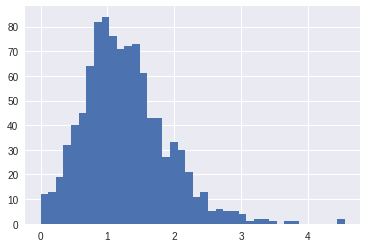

In [7]:
client_data=[gen_client_data() for k in range(1000)]
client_scores=[customer_score(c) for c in client_data]
plt.hist(client_scores, bins=40)

In [0]:
def gen_client_dataset(n=1000, threshold = 1.5):
    client_data   =[gen_client_data() for k in range(n)]
    client_returns=[int(customer_score(c)>=threshold) for c in client_data]
    
    return client_data, client_returns

In [0]:
x_train, y_train = gen_client_dataset(n=150000)
x_val, y_val     = gen_client_dataset(n=1200)
x_test, y_test   = gen_client_dataset(n=1000)

# Model

In [10]:
#learning
from keras import Model
from keras import layers as L
from keras import backend as K
import numpy as np

#add two parent levels to path
import os,sys,inspect
currentdir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
parentdir = os.path.dirname(os.path.dirname(currentdir))
sys.path.insert(0,parentdir) 

%load_ext autoreload
%autoreload 2

import IntelligentElement as IE

Using TensorFlow backend.


In [0]:
nn_hidden_sizes=48
nn_depth=12

# order data

In [20]:
def preproc_order(rec):
    orders = [np.array(v['order']) for v in rec['last_30']]    
    return orders

#model
order_shape = (None, None, 2)
inp = L.Input( order_shape )
x = inp

#for k in range(nn_depth):
#    x = L.Dense(nn_hidden_sizes,activation='relu')(x)
    
#x1 = L.TimeDistributed(L.GlobalAveragePooling1D(), name='td_avgpooling')(x)
#x2 = L.TimeDistributed(L.GlobalMaxPooling1D(), name='td_maxpooling')(x)
#x  = L.Concatenate()([x1,x2])
x = L.TimeDistributed(L.CuDNNLSTM(nn_hidden_sizes),name='lstm_order')(x)

order_model = Model(inputs=inp, outputs=x)
order_model.summary()

order_ie = IE.IntelligentElement(x_train, order_model, order_shape, preprocess_function=preproc_order, 
                                val_data=x_val, test_data=x_test, name='order_ie')

m, ii, oo = order_ie.retrieve_model_inputs_outputs()
print('\n\nRetrieved model')
m.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         (None, None, None, 2)     0         
_________________________________________________________________
lstm_order (TimeDistributed) (None, None, 48)          9984      
Total params: 9,984
Trainable params: 9,984
Non-trainable params: 0
_________________________________________________________________


Retrieved model
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inp_order_ie (InputLayer)    (None, None, None, 2)     0         
_________________________________________________________________
m_order_ie (Model)           (None, None, 48)          9984      
Total params: 9,984
Trainable params: 9,984
Non-trainable params: 0
_________________________________________________________________


# days

In [21]:
def preproc_day(rec):
    day_data = [np.array([x['present'], x['rating'], x['time_spent']]) for x in rec['last_30']]
    return day_data

#model
day_shape = (None, 3)
inp = L.Input( (None, order_ie.model.output_shape[-1] + day_shape[-1]) )
x = inp

#for k in range(nn_depth):
#    x = L.Dense(nn_hidden_sizes,activation='relu')(x)
#x = L.GlobalAveragePooling1D(name='day_pool')(x)
x = L.CuDNNLSTM(nn_hidden_sizes)(x)

day_model = Model(inputs=inp, outputs=x)
day_model.summary()

day_ie = IE.IntelligentElement(x_train, day_model, day_shape, preprocess_function=preproc_day, children_ie=order_ie,
                                val_data=x_val, test_data=x_test, name='day_ie')

m, ii, oo = day_ie.retrieve_model_inputs_outputs()
print('\n\nRetrieved model')
m.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         (None, None, 51)          0         
_________________________________________________________________
cu_dnnlstm_3 (CuDNNLSTM)     (None, 48)                19392     
Total params: 19,392
Trainable params: 19,392
Non-trainable params: 0
_________________________________________________________________


Retrieved model
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
inp_order_ie (InputLayer)       (None, None, None, 2 0                                            
__________________________________________________________________________________________________
m_order_ie (Model)              (None, None, 48)     9984        inp_order_ie[0][0]               
_____________________

## root

In [22]:
def preproc_root(rec):
    return np.array([(rec['age']-12)/70, rec['gender'], rec['n_children']/5., rec['income']])

#model
root_shape = (4,)
inp = L.Input( (root_shape[0]+day_ie.model.output_shape[-1],) )
x = inp
for k in range(nn_depth):
    x = L.Dense(nn_hidden_sizes,activation='relu')(x)
x = L.Dense(1, activation='sigmoid')(x)
root_model = Model(inputs=inp, outputs=x)

root_ie = IE.IntelligentElement(x_train, root_model, root_shape, preprocess_function=preproc_root, children_ie=[day_ie],
                                val_data=x_val, test_data=x_test, name='root_ie')

m, ii, oo = root_ie.retrieve_model_inputs_outputs()
print('\n\nRetrieved model')
m.summary()



Retrieved model
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
inp_order_ie (InputLayer)       (None, None, None, 2 0                                            
__________________________________________________________________________________________________
m_order_ie (Model)              (None, None, 48)     9984        inp_order_ie[0][0]               
__________________________________________________________________________________________________
inp_day_ie (InputLayer)         (None, None, 3)      0                                            
__________________________________________________________________________________________________
concatenate_6 (Concatenate)     (None, None, 51)     0           m_order_ie[3][0]                 
                                                                 inp_day_ie[0][0]          

# Training

Using the generator to get data batches is recommended because IntelligentElement framework pads to the correct list size.

In [0]:
train_gen = IE.IEDataGenerator(root_ie, y_train, from_set = 'train', batch_size=128, labeltype=int, shuffle=True)
val_gen   = IE.IEDataGenerator(root_ie, y_val,   from_set = 'val',   batch_size=128, labeltype=int, shuffle=False)
test_gen  = IE.IEDataGenerator(root_ie, y_test,  from_set = 'test',  batch_size=128, labeltype=int, shuffle=False)

In [0]:
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

m.compile(optimizer=Adam(lr=1e-3, clipvalue=0.5), loss='binary_crossentropy', metrics=['binary_accuracy']) #, metrics=[mean_iou, 'categorical_accuracy'])

earlystopper = EarlyStopping(patience=15, verbose=1, monitor='val_binary_accuracy')
checkpointer = ModelCheckpoint('model-customer_pred.h5', verbose=1, save_best_only=True, monitor='val_binary_accuracy')
reduce_lr = ReduceLROnPlateau(factor=0.5, patience=5, min_lr=1e-5, verbose=1, monitor='loss')

In [27]:
results = m.fit_generator(train_gen, epochs=100, 
                          #use_multiprocessing = False, workers=4,
                          validation_data=val_gen,
                          callbacks=[earlystopper, checkpointer, reduce_lr])

Epoch 1/100
1171/1171 [==============================] - 65s 56ms/step - loss: 0.4125 - binary_accuracy: 0.8036 - val_loss: 0.6094 - val_binary_accuracy: 0.7257

Epoch 00001: val_binary_accuracy improved from -inf to 0.72569, saving model to model-customer_pred.h5
Epoch 2/100
1171/1171 [==============================] - 63s 54ms/step - loss: 0.4034 - binary_accuracy: 0.8082 - val_loss: 0.5797 - val_binary_accuracy: 0.7196

Epoch 00002: val_binary_accuracy did not improve from 0.72569
Epoch 3/100
1171/1171 [==============================] - 64s 55ms/step - loss: 0.3963 - binary_accuracy: 0.8114 - val_loss: 0.5983 - val_binary_accuracy: 0.7283

Epoch 00003: val_binary_accuracy improved from 0.72569 to 0.72830, saving model to model-customer_pred.h5
Epoch 4/100
1171/1171 [==============================] - 64s 55ms/step - loss: 0.3905 - binary_accuracy: 0.8157 - val_loss: 0.6405 - val_binary_accuracy: 0.7196

Epoch 00004: val_binary_accuracy did not improve from 0.72830
Epoch 5/100
1171/11

In [28]:
train_eval = m.evaluate_generator(train_gen, verbose=1)
val_eval   = m.evaluate_generator(val_gen, verbose=1)
test_eval  = m.evaluate_generator(test_gen, verbose=1)
print('Train: {}\nVal:{}\nTest{}'.format(train_eval,val_eval,test_eval))

7/7 [==============================] - 0s 34ms/step
Train: [0.19080555304108676, 0.9172115179333903]
Val:[1.1515069471465216, 0.6701388888888888]
Test[1.188374902520861, 0.6863839285714286]
